In [7]:
%load_ext autoreload
%autoreload 2

import dataclasses
import logging
import pathlib

import numpy as np
import pandas as pd
import sklearn.ensemble as ensemble
import sklearn.metrics
import sklearn.model_selection
import xarray as xr

import a6
import a6.datasets.coordinates as _coordinates
import a6.datasets.variables as _variables
import a6.utils as utils
import a6.plotting._colors as _colors

WORKER_ID = 4

utils.logging.create_logger(
    global_rank=WORKER_ID,
    local_rank=WORKER_ID,
    verbose=True,
)

logger = logging.getLogger("notebook")


turbine_data_dir = pathlib.Path(
    "/p/home/jusers/emmerich1/juwels/data/production"
)
preprocessed_data_dir = pathlib.Path(
    "/p/home/jusers/emmerich1/juwels/data/production-preprocessed"
)
results_dir = pathlib.Path(
    "/p/project1/deepacf/emmerich1/data/forecast-errors"
)

turbine_files = a6.utils.paths.list_files(
    turbine_data_dir, pattern="**/*.nc", recursive=True
)

turbine_error_files = a6.utils.paths.list_files(
    results_dir, pattern="*.nc", recursive=False
)
turbine_errors = [xr.open_dataset(path) for path in turbine_error_files]

plots = pathlib.Path("/p/project1/deepacf/emmerich1/plots")

results = xr.open_dataset(
    "/p/project1/deepacf/emmerich1/data/pca_kmeans_lswrs_30_40.nc"
)
n_lswr_categories = 30
results_pca = results.sel(k=n_lswr_categories)
gwl = xr.open_dataset("../src/tests/data/gwl.nc")
dcv2 = xr.open_dataset("/p/project1/deepacf/emmerich1/data/dcv2-lswrs.nc")

lswrs = [
    "Default",
    dcv2["DCv2"],
    results_pca["PCA"],
    gwl["GWL"],
    "Random",
]

coordinates: _coordinates.Coordinates = _coordinates.Coordinates()
turbine_variables: _variables.Turbine = a6.datasets.variables.Turbine()

turbines_with_preprocessed_data = [
    path
    for path in turbine_files
    if (
        preprocessed_data_dir / f"{path.name.replace('.nc', '')}/turbine.nc"
    ).exists()
]
print(f"Number of turbines: {len(turbines_with_preprocessed_data)}")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Number of turbines: 40


In [3]:
gwl_labels_map = {int(k): v for k, v in gwl.attrs.items()}
gwl_labels = list(gwl_labels_map.values())
gwl_labels_map, gwl_labels

({1: 'XXAAT',
  2: 'NOAAT',
  3: 'SOAAT',
  4: 'SWAAT',
  5: 'NWAAT',
  6: 'XXAAF',
  7: 'NOAAF',
  8: 'SOAAF',
  9: 'SWAAF',
  10: 'NWAAF',
  11: 'XXAZT',
  12: 'NOAZT',
  13: 'SOAZT',
  14: 'SWAZT',
  15: 'NWAZT',
  16: 'XXAZF',
  17: 'NOAZF',
  18: 'SOAZF',
  19: 'SWAZF',
  20: 'NWAZF',
  21: 'XXZAT',
  22: 'NOZAT',
  23: 'SOZAT',
  24: 'SWZAT',
  25: 'NWZAT',
  26: 'XXZAF',
  27: 'NOZAF',
  28: 'SOZAF',
  29: 'SWZAF',
  30: 'NWZAF',
  31: 'XXZZT',
  32: 'NOZZT',
  33: 'SOZZT',
  34: 'SWZZT',
  35: 'NWZZT',
  36: 'XXZZF',
  37: 'NOZZF',
  38: 'SOZZF',
  39: 'SWZZF',
  40: 'NWZZF'},
 ['XXAAT',
  'NOAAT',
  'SOAAT',
  'SWAAT',
  'NWAAT',
  'XXAAF',
  'NOAAF',
  'SOAAF',
  'SWAAF',
  'NWAAF',
  'XXAZT',
  'NOAZT',
  'SOAZT',
  'SWAZT',
  'NWAZT',
  'XXAZF',
  'NOAZF',
  'SOAZF',
  'SWAZF',
  'NWAZF',
  'XXZAT',
  'NOZAT',
  'SOZAT',
  'SWZAT',
  'NWZAT',
  'XXZAF',
  'NOZAF',
  'SOZAF',
  'SWZAF',
  'NWZAF',
  'XXZZT',
  'NOZZT',
  'SOZZT',
  'SWZZT',
  'NWZZT',
  'XXZZF',
  'NOZZF',
 

## Create single forecast with different LSWRs as input

In [4]:
@dataclasses.dataclass
class Errors:
    nmae: float
    nrmse: float


def _create_forecast(
    date: pd.Timestamp,
    gs: sklearn.model_selection.GridSearchCV,
    weather_data: list[xr.DataArray],
    turbine: xr.Dataset,
    turbine_variables: _variables.Turbine,
) -> tuple[np.ndarray, pd.Timestamp]:
    logger.debug("Creating forecast for %s", date)

    turbine_sub = a6.datasets.methods.select.select_for_date(
        turbine, date=date
    )[turbine_variables.production]
    y_true = a6.features.methods.reshape.sklearn.transpose(turbine_sub)

    if y_true.size < 24:
        logger.warning(
            (
                "Less than 24 time steps for production data for date=%s, "
                "returning empty array"
            ),
            date,
        )
        return np.array([]), date

    weather_forecast = [
        a6.datasets.methods.select.select_for_date(d, date=date)
        for d in weather_data
    ]
    X_forecast = a6.features.methods.reshape.sklearn.transpose(  # noqa: N806
        *weather_forecast
    )

    y_pred = gs.predict(X_forecast)
    return y_pred, date

In [ ]:
if WORKER_ID is not None and WORKER_ID >= len(turbine_files):
    logger.warning("Exiting: no file to process")
    raise RuntimeError()


result = {}

for i, turbine_path in enumerate(turbine_files):
    if WORKER_ID is not None and i != WORKER_ID:
        continue

    logger.info(
        "Processing turbine %i/%i (path=%s)",
        i,
        len(turbine_files),
        turbine_path,
    )

    turbine_name = turbine_path.name.replace(".nc", "")

    turbine_path: pathlib.Path = (
        preprocessed_data_dir / f"{turbine_name}/turbine.nc"
    )
    pl_path: pathlib.Path = preprocessed_data_dir / f"{turbine_name}/pl.nc"
    ml_path: pathlib.Path = preprocessed_data_dir / f"{turbine_name}/ml.nc"
    sfc_path: pathlib.Path = preprocessed_data_dir / f"{turbine_name}/sfc.nc"

    logger.info("Reading preprocessed data")

    try:
        turbine = xr.open_dataset(turbine_path)
    except FileNotFoundError:
        logger.exception(
            "No preprocessed data for turbine %s found in %s",
            turbine_name,
            turbine_path,
        )
        continue

    pl = xr.open_dataset(pl_path)
    ml = xr.open_dataset(ml_path)
    sfc = xr.open_dataset(sfc_path)

    power_rating = turbine_variables.read_power_rating(turbine)
    logger.info("Extracted power rating %i", power_rating)

    # Convert time stamps to dates and create date range
    times_as_dates = a6.utils.times.time_steps_as_dates(
        turbine, coordinates=coordinates
    )
    start, end = min(times_as_dates), max(times_as_dates)
    dates = pd.date_range(start, end, freq="1d")

    logger.info(
        "Simulating forecast errors for LSWRS %s for date range %s to %s",
        lswrs,
        start,
        end,
    )

    forecasts = {}

    for lswr in lswrs:
        if lswr == "Random":
            logger.warning("Skipping Random LSWR labels")

        lswr_name = lswr if isinstance(lswr, str) else lswr.name

        logger.info("Handling LSWR %s", lswr_name)

        outfile: pathlib.Path = (
            results_dir / f"{turbine_name}-forecast-errors-lswr-{lswr_name}.nc"
        )

        if outfile.exists():
            logger.warning(
                "Skipping %s since outfile already exists at %s",
                turbine_path,
                outfile,
            )

        data = (
            [ml[var] for var in ml.data_vars]
            + [sfc[var] for var in sfc.data_vars]
            + [pl[var] for var in pl.data_vars]
        )
        categorical_features = [False for _ in enumerate(data)]

        if lswr == "Default":
            lswr_labels = lswr.sel(time=turbine[coordinates.time], method="pad")
            data.append(lswr_labels)
            categorical_features.append(True)

        logger.info(
            "Preparing input data for variables %s", [d.name for d in data]
        )

        X = a6.features.methods.reshape.sklearn.transpose(*data)  # noqa: N806
        y = a6.features.methods.reshape.sklearn.transpose(
            turbine[turbine_variables.production]
        )

        (  # noqa: N806
            X_train,
            _,
            y_train,
            _,
        ) = sklearn.model_selection.train_test_split(X, y, train_size=1 / 3)

        logger.info(
            "Train dataset size is %i hours (~%i days)",
            y_train.size,
            y_train.size // 24,
        )

        logger.info("Fitting model with GridSearchCV")

        param_grid = {
            "learning_rate": [0.03, 0.05, 0.07, 0.1],
            "l2_regularization": [0.0, 1.0, 3.0, 5.0, 7.0],
            "max_iter": [200, 300, 500],
            "max_depth": [15, 37, 63, 81],
            "min_samples_leaf": [23, 48, 101, 199],
            "categorical_features": [categorical_features],
        }
        n_jobs = int(a6.utils.get_cpu_count())

        gs = sklearn.model_selection.GridSearchCV(
            estimator=ensemble.HistGradientBoostingRegressor(
                loss="squared_error"
            ),
            param_grid=param_grid,
            scoring=sklearn.metrics.make_scorer(
                a6.training.metrics.turbine.calculate_nrmse,
                greater_is_better=False,
                power_rating=power_rating,
            ),
            # 10-fold CV
            cv=10,
            refit=True,
            n_jobs=n_jobs,
        )
        gs = gs.fit(X=X_train, y=y_train.ravel())

        for date in dates:
            if lswr_name in forecasts:
                break

            forecast, date = _create_forecast(
                date=date,
                gs=gs,
                weather_data=data,
                turbine=turbine,
                turbine_variables=turbine_variables,
            )

            if forecast.size != 0:
                forecasts[lswr_name] = (forecast, date)

In [ ]:
import joblib

forecasts_default = forecasts.pop("none")
forecasts["Default"] = forecasts_default

joblib.dump(
    forecasts, "/p/project1/deepacf/emmerich1/data/forecasts-per-method.joblib"
)

forecasts

## Plot forecasts for LSWR inputs

In [ ]:
import matplotlib.pyplot as plt
import joblib

forecasts = joblib.load(
    "/p/project1/deepacf/emmerich1/data/forecasts-per-method.joblib"
)

turbine_path = turbine_files[WORKER_ID]
turbine_name = turbine_path.name.replace(".nc", "")
turbine_path: pathlib.Path = (
    preprocessed_data_dir / f"{turbine_name}/turbine.nc"
)
turbine = xr.open_dataset(turbine_path)
print(turbine)

forecast, date = forecasts["PCA"]
x = list(range(forecast.size))
xticklabels = [
    s.strftime("%H:%M")
    for s in pd.date_range(start="2000-01-01", end="2000-01-02", freq="1h")
][:-1]

plt.figure(figsize=(8, 3))

actual = a6.datasets.methods.select.select_for_date(turbine, date=date)[
    turbine_variables.production
]

plt.plot(x, actual, label="Production", color="black", linestyle="--")

plt.plot(
    x, forecasts["Default"][0], label="Default", color="black", linestyle=":"
)

for method, (forecast, _) in forecasts.items():
    if method == "Default":
        continue
    plt.plot(x, forecast, label=method)

plt.xticks()
plt.legend(ncol=3)
plt.ylabel("$P$ [kW]")

plt.xticks(x, xticklabels, rotation=45)
plt.xlabel("time")

plt.xlim(-0.5, 24)
plt.savefig(plots / "forecasts-per-method.pdf", bbox_inches="tight")

## Plot turbine positions

In [9]:
coordinates = []

for i, turbine_path in enumerate(turbines_with_preprocessed_data):
    turbine = xr.open_dataset(turbine_path)
    lon, lat = (
        turbine["longitude"].values.tolist()[0],
        turbine["latitude"].values.tolist()[0],
    )
    coordinates.append((lon, lat))

coordinates

[(13.797544444, 53.437352778),
 (13.825041667, 53.442397222),
 (13.814813889, 53.437161111),
 (11.2027447222222, 52.1987261111111),
 (14.0722222222222, 52.6833333333333),
 (14.405243, 52.27888889),
 (14.43493, 52.29611111),
 (13.7463083333333, 53.781725),
 (13.769943, 51.965198),
 (11.435, 52.1627777777777),
 (13.7421666666666, 53.3444055555555),
 (12.2661194444444, 52.2102944444444),
 (12.2675888888888, 52.2023416666666),
 (12.2758305555555, 52.2021027777777),
 (13.8353527777777, 53.3934055555555),
 (13.8368361111111, 53.3903805555555),
 (13.8368833333333, 53.38585),
 (13.8342083333333, 53.3995694444444),
 (13.8363972222222, 53.3965166666666),
 (13.8309583333333, 53.3951861111111),
 (13.7927083333333, 53.4370638888888),
 (13.8217972222222, 53.4379),
 (13.8563972222222, 53.4731416666666),
 (13.8632166666666, 53.4722),
 (13.8694694444444, 53.4722055555555),
 (13.8539138888888, 53.4701777777777),
 (13.8505361111111, 53.467475),
 (13.8662166666666, 53.4669972222222),
 (13.6330352777777, 5

RANK 4 (LOCAL 4) - DEBUG - 2024-10-01 16:24:51 - 0:00:35 - Assigning font /F1 = '/venv/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf'
RANK 4 (LOCAL 4) - DEBUG - 2024-10-01 16:24:51 - 0:00:35 - Embedding font /venv/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf.
RANK 4 (LOCAL 4) - DEBUG - 2024-10-01 16:24:51 - 0:00:35 - Writing TrueType font.


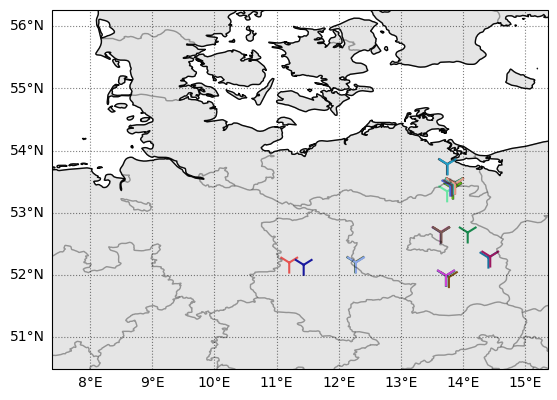

In [10]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.io.shapereader as shapereader
import cartopy.feature as cfeature

ax = plt.axes(projection=ccrs.PlateCarree())
ax.add_feature(cfeature.LAND, edgecolor="black", facecolor="none", linewidth=1)

# get country borders
resolution = "10m"
category = "cultural"
name = "admin_1_states_provinces"
shpfilename = shapereader.natural_earth(resolution, category, name)
adm1_shapes = list(shapereader.Reader(shpfilename).geometries())


x, y = [x[0] for x in coordinates], [x[1] for x in coordinates]
ax.scatter(
    x,
    y,
    marker="1",
    s=250,
    c=[a6.plotting._colors.LABEL_COLORS[i] for i in range(len(coordinates))],
)

# Just plotted to avoid calling `ax.set_extent()`, which crashes the kernel
ax.scatter(
    [7.75, 15.0, 7.75, 15.0],  # longitudes
    [50.75, 50.75, 56.0, 56.0],  # latitudes
    alpha=0,
)

ax.add_geometries(
    adm1_shapes,
    ccrs.PlateCarree(),
    edgecolor="black",
    facecolor="gray",
    alpha=0.2,
)

ax.gridlines(
    crs=ccrs.PlateCarree(),
    color="black",
    alpha=0.5,
    linestyle=":",
    draw_labels=["left", "bottom"],
)

plt.savefig(plots / "turbine-positions.pdf", bbox_inches="tight")

## Summarize turbine properties in table

In [24]:
import json

with open("/p/home/jusers/emmerich1/juwels/data/samples_removed.json", "r") as f:
    samples_removed_map = json.loads(f.read())

In [25]:
def extract_turbine_data(path: pathlib.Path):
    d = xr.open_dataset(path)

    samples_removed = samples_removed_map[path.name.replace(".nc", "")]

    lat, lon = float(d["latitude"]), float(d["longitude"])
    altitude = float(d["level"])
    power_rating = float(d.attrs["power rating"].split(" ")[0]) * 1e-3
    hub_height = float(d.attrs["hub height"].split(" ")[0])
    start, end = (
        utils.times.numpy_datetime64_to_datetime(d["time"][0].values).strftime(
            "%Y-%m-%d"
        ),
        utils.times.numpy_datetime64_to_datetime(d["time"][-1].values).strftime(
            "%Y-%m-%d"
        ),
    )
    return [
        f"{lat:.1f}",
        f"{lon:.1f}",
        f"{altitude:.1f}",
        f"{hub_height:.0f}",
        f"{power_rating:.1f}",
        f"{start}--{end}",
        samples_removed, 
    ]


data = [
    extract_turbine_data(path)
    for path in turbines_with_preprocessed_data
]

df = pd.DataFrame(
    data=data,
    columns=[
        "Lat.",
        "Lon.",
        "Alt. [m]",
        "Hub height [m]",
        "Nominal power [MW]",
        "Time range",
        "# time steps removed",
    ],
)
code = df.to_latex(
    float_format="%.2f",
    label="turbines",
    index=False,
    column_format="rrrrrcc",
    caption="""
    Properties of the wind turbines:
	geographical location (latitude, longitude, altitude),
	hub height, nominal power,
	time range of available power production data
	of the corresponding turbine, and the amount of 10-minute time steps removed by the
    data cleaning process.
    """,
)


with open(
    "/p/home/jusers/emmerich1/juwels/code/a6/notebooks/turbines-table.tex", "w"
) as f:
    f.write(code)

df

,Lat.,Lon.,Alt. [m],Hub height [m],Nominal power [MW],Time range,# time steps removed
0,53.4,13.8,53.0,135,3.6,2019-09-09--2021-07-18,29.648 (31.06\%)
1,53.4,13.8,63.0,123,4.2,2019-09-12--2021-07-18,21.909 (22.91\%)
2,53.4,13.8,47.0,123,4.2,2019-09-30--2021-07-18,22.769 (24.38\%)
3,52.2,11.2,151.5,60,0.8,2017-01-01--2021-07-18,60.245 (25.68\%)
4,52.7,14.1,75.0,105,2.0,2017-01-01--2021-07-18,49.875 (21.91\%)
5,52.3,14.4,93.0,105,2.0,2017-01-01--2021-07-18,45.557 (19.44\%)
6,52.3,14.4,89.0,108,2.0,2017-01-01--2021-07-18,21.203 (9.07\%)
7,53.8,13.7,9.0,105,2.0,2017-01-01--2021-07-18,60.570 (25.86\%)
8,52.0,13.8,52.4,149,3.5,2018-12-13--2021-07-18,24.573 (18.19\%)
9,52.2,11.4,126.0,95,2.0,2017-01-01--2021-07-18,55.502 (24.04\%)


## Summarize errors for every LSWR

In [ ]:
import dataclasses
import datetime


@dataclasses.dataclass
class ErrorsPerLswr:
    label: int
    measurements: list[int] = dataclasses.field(default_factory=list)
    nmae: list[int] = dataclasses.field(default_factory=list)
    nrmse: list[int] = dataclasses.field(default_factory=list)


def get_errors_per_lswr(data: xr.Dataset) -> dict[int, ErrorsPerLswr]:
    modes = a6.modes.methods.determine_lifetimes_of_modes(data)
    dates = [xr.DataArray(list(mode.get_dates())) for mode in modes]

    errors_per_mode = {
        mode.label: ErrorsPerLswr(label=mode.label) for mode in modes
    }

    for i, turbine in enumerate(turbine_errors):
        print(f"{data.name}: {i}/{len(turbine_errors)}", end="\r")

        for mode, date in zip(modes, dates, strict=True):
            mode_power = errors_per_mode[mode.label]

            # Get time steps of production where LSWR appeared
            intersection = sorted(set(turbine.time.values) & set(date.values))

            if not intersection:
                logger.warning(
                    f"{data.name}: empty intersection for {i} and mode {mode.label}"
                )
                continue

            turbine_sub = turbine.sel(time=intersection, lswr_method="Default")

            # Count number of days that contribute to the results
            mode_power.measurements.append(len(intersection))

            # Select time steps of LSWR appearance and calculate mean
            nmae = turbine_sub["nmae"]
            mode_power.nmae.extend(nmae.values.flatten().tolist())

            nrmse = turbine_sub["nrmse"]
            mode_power.nrmse.extend(nrmse.values.flatten().tolist())

    return errors_per_mode


errors_per_method = {
    lswr.name: get_errors_per_lswr(lswr)
    for lswr in lswrs
    if isinstance(lswr, xr.DataArray)
}

In [ ]:
import pandas as pd


def errors_mean_with_std_as_string(stats: list[float]) -> str:
    return f"${np.nanmean(stats) * 100:.2f} \pm {np.nanstd(stats) * 100:.2f}$"


latex_code = []
columns = {
    "$N$": lambda lswrs: [
        np.nansum(results.measurements) for results in lswrs.values()
    ],
    "NMAE [\%]": lambda lswrs: [
        errors_mean_with_std_as_string(results.nmae)
        for results in lswrs.values()
    ],
    "NRMSE [\%]": lambda lswrs: [
        errors_mean_with_std_as_string(results.nrmse)
        for results in lswrs.values()
    ],
}

reform = {
    (name, column): func(method)
    for name, method in errors_per_method.items()
    for column, func in columns.items()
}

df = pd.DataFrame.from_dict(reform)

# Add 1 to start indexing at 1 to be conform with LSWR labels
df.index += 1

code = df.to_latex(
    float_format="%.2f",
    label="errors-per-lswr-per-method",
    caption=f"Normalized MAE and RMSE of the Default model for the resulting LSWRs.",
)


with open(
    "/p/home/jusers/emmerich1/juwels/code/a6/notebooks/errors-table.tex", "w"
) as f:
    f.write(code)


df

In [ ]:
import matplotlib.pyplot as plt


def plot_errors_per_method(
    errors: dict[str, dict[int, ErrorsPerLswr]],
) -> tuple[plt.Figure, plt.Axes]:
    """Plot the mean and std of NMAE and NRMSE for each LSWR and method."""
    n_rows = len(errors)
    n_cols = 2  # 1 column for NMAE and 1 for NRMSE
    labels = np.arange(1, n_lswr_categories + 1, dtype=int)

    x_lims = labels.min() - 0.5, labels.max() + 0.5
    colors = _colors.create_colors_for_labels(labels)

    fig, axs = plt.subplots(
        figsize=(6 * n_cols, 2 * n_rows),
        nrows=n_rows,
        ncols=n_cols,
        sharex=True,
        sharey=True,
    )

    plt.title(f"Errors per LSWRs")

    for i, (method, errors_per_lswr) in enumerate(errors.items()):
        for j, metric in enumerate(("nrmse", "nmae")):
            error_means = [
                np.nanmean(getattr(error, metric)) * 100
                for error in errors_per_lswr.values()
            ]
            error_stds = [
                np.nanstd(getattr(error, metric)) * 100
                for error in errors_per_lswr.values()
            ]
            ax = axs[i][j]

            ax.bar(
                labels,
                error_means,
                yerr=error_stds,
                width=1.0,  # removes gaps between the bars
                color=colors,
                align="center",
                alpha=1,
                ecolor="black",
                capsize=3,
            )

            ax.set_title(method)

            if i == n_rows - 1:
                ax.set_xlabel("LSWR")

            ax.set_ylabel(f"{metric.upper()} [%]")
            ax.set_xlim(*x_lims)
            ax.set_xticks(labels)
            ax.set_xticklabels(labels, rotation=90)
            ax.yaxis.grid(True)

    fig.tight_layout()
    plt.savefig(plots / "lswrs-errors-comparison.pdf", bbox_inches="tight")


plot_errors_per_method(errors_per_method)

## Create timeseries plot with NRMSE for every LSWR method

In [ ]:
import pandas as pd
import dataclasses
import datetime

start, end = min(min(turbine.time.values) for turbine in turbine_errors), max(
    max(turbine.time.values) for turbine in turbine_errors
)
date_range = pd.date_range(start, end, freq="1d")
date_range


@dataclasses.dataclass
class ErrorsPerDay:
    time: pd.Timestamp
    measurements: int = 0
    nmae: list[int] = dataclasses.field(default_factory=list)
    nrmse: list[int] = dataclasses.field(default_factory=list)


def get_errors_per_day(
    data: xr.DataArray | None,
) -> dict[pd.Timestamp, ErrorsPerDay]:
    name = data.name if isinstance(data, xr.DataArray) else data
    errors_per_day = {step: ErrorsPerDay(time=step) for step in date_range}

    for i, step in enumerate(date_range):
        day_errors = errors_per_day[step]

        for j, turbine in enumerate(turbine_errors):
            print(
                f"{name}: day {i}/{len(date_range)}, turbine {j}/{len(turbine_errors)}",
                end="\r",
            )

            if step not in turbine["time"]:
                continue

            turbine_sub = turbine.sel(time=step, lswr_method=name)

            # Add to counter for turbines that contribute to the results
            day_errors.measurements += 1

            # Select time steps of LSWR appearance and calculate mean
            nmae = turbine_sub["nmae"]
            day_errors.nmae.append(nmae.values.tolist())

            nrmse = turbine_sub["nrmse"]
            day_errors.nrmse.append(nrmse.values.tolist())

    return errors_per_day


errors_per_day = {
    (lswr.name if isinstance(lswr, xr.DataArray) else lswr): get_errors_per_day(
        lswr
    )
    for lswr in lswrs
}

In [ ]:
import matplotlib.pyplot as plt

n_rows = len(lswrs)

fig, axs = plt.subplots(
    figsize=(12, 4 * n_rows), nrows=n_rows, ncols=1, sharex=True
)

means_per_day = []
stds_per_day = []

attr = "nmae"

for results in errors_per_day.values():
    mean_per_day = (
        np.array([np.nanmean(getattr(day, attr)) for day in results.values()])
        * 100
    )
    std_per_day = (
        np.array([np.nanstd(getattr(day, attr)) for day in results.values()])
        * 100
    )

    means_per_day.append(mean_per_day)
    stds_per_day.append(std_per_day)

x_start, x_end = 100, 300

global_max = np.nanmax(
    [
        np.nanmax(m[x_start:x_end] + s[x_start:x_end])
        for m, s in zip(means_per_day, stds_per_day)
    ]
)
global_min = np.nanmin(
    [
        np.nanmin(m[x_start:x_end] - s[x_start:x_end])
        for m, s in zip(means_per_day, stds_per_day)
    ]
)

# If global minimum is lower than 2%, set it to 0.
# This is used for the ylim in each plot
if global_min < 2.0:
    global_min = 0.0

x = list(range(len(date_range)))

for i, (name, results) in enumerate(errors_per_day.items()):
    ax = axs[i]

    mean_per_day = means_per_day[i]
    std_per_day = stds_per_day[i]

    all_errs = (
        np.array(
            [nrmse for day in results.values() for nrmse in getattr(day, attr)]
        )
        * 100
    )
    global_mean = np.nanmean(all_errs)
    global_std = np.nanstd(all_errs)

    ax.plot(
        x,
        mean_per_day,
    )
    ax.fill_between(
        x,
        mean_per_day - std_per_day,
        mean_per_day + std_per_day,
        color="gray",
        alpha=0.5,
    )

    # Plot global mean and standard deviation
    ax.hlines(
        y=global_mean,
        xmin=-10,
        xmax=x[-1] + 10,
        linewidth=1,
        linestyle="--",
        color="black",
        label=rf"$\mu_\mathrm{{{attr.upper()}}}^\mathrm{{global}} = ({global_mean:.2f} \pm {global_std:.2f})\,\%$",
    )

    ax.hlines(
        y=global_mean + global_std,
        xmin=-10,
        xmax=x[-1] + 10,
        linewidth=1,
        linestyle=":",
        color="black",
    )
    ax.hlines(
        y=global_mean - global_std,
        xmin=-10,
        xmax=x[-1] + 10,
        linewidth=1,
        linestyle=":",
        color="black",
    )

    ax.set_title(name)

    ax.set_xlim(x_start, x_end)

    if i == n_rows - 1:
        ax.set_xlabel("time")
        xticks = ax.get_xticks()
        xticklabels = [
            date_range[int(tick)].strftime("%Y-%m-%d") for tick in xticks[1:]
        ]
        ax.set_xticklabels(xticklabels, rotation=45)
    else:
        ax.set_xticklabels([])

    ax.set_ylabel(rf"$\mu_\mathrm{{{attr.upper()}}}$ [%]")

    ax.set_ylim(global_min * 0.9, global_max * 1.05)
    ax.legend()

fig.tight_layout()
plt.savefig(plots / f"forecast-error-timeseries-per-lswr-method-{attr}.pdf", bbox_inches="tight")